## EXPLORATORY DATA  ANALYSIS

#### Predicting claim frequencies (expected claim count per unit of exposure) expressed as rate. Is the base for key calculations: pricing, reserving, ruin probabilities and reinsurance.

#### We'll work on a data set comprising a French motor third-party liability insurance portfolio of 600k exposure (policies) with corresponding claim counts observed in one accounting year.

- Import the libraries neccesary for the analysis

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import src.tools as cf

In [55]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (20.,9.)})
sns.set_style("whitegrid")

In [56]:
claimsdf = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/ProyectoFinal/Claims-Frequency-Predictions/freMTPL2freq.csv')

#### OUR DATA SET: A portfolio of 600 k car insurance policies in France, for one accounting year

In [57]:
claimsdf.head(3)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22


In [58]:
claimsdf.shape

(678013, 12)

In [59]:
claimsdf.dtypes

IDpol         float64
ClaimNb         int64
Exposure      float64
Area           object
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Density         int64
Region         object
dtype: object

#### We'll add a colum with the empirical frequencies (observed) for each policy

In [60]:
claimsdf['empirical_frequencies'] = (claimsdf.ClaimNb / claimsdf.Exposure)

### CLAIM-NB: Claim counts per policy

#### We'll start with our target variable. Analyzing how the Claims distribute over the portfolio

In [61]:
claims_min = claimsdf.ClaimNb.min()
claims_max = claimsdf.ClaimNb.max()
claims_mean = claimsdf.ClaimNb.mean()
claims_med = claimsdf.ClaimNb.median()
claims_mod = claimsdf.ClaimNb.mode()
claims_min, claims_max, claims_mean, claims_med, claims_mod

(0,
 16,
 0.05324676665491664,
 0.0,
 0    0
 dtype: int64)

In [62]:
claimsdf.ClaimNb.unique()

array([ 1,  2,  4,  3, 11,  0,  5,  6,  8, 16,  9])

In [63]:
data = {'ClaimNb': [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 16],
        'year': [2000, 2001, 2002, 2001, 2002, 2003],
        'pop': [1.5, 1.7, 3.6, 2.4, 2.9, np.nan]}

#### !!! AGREGAR DF CON LOS UNIQUE COMO COLUMN Y LOS COUNTS EN LA FILA, Y LA EMP FREQ TOTAL !!!

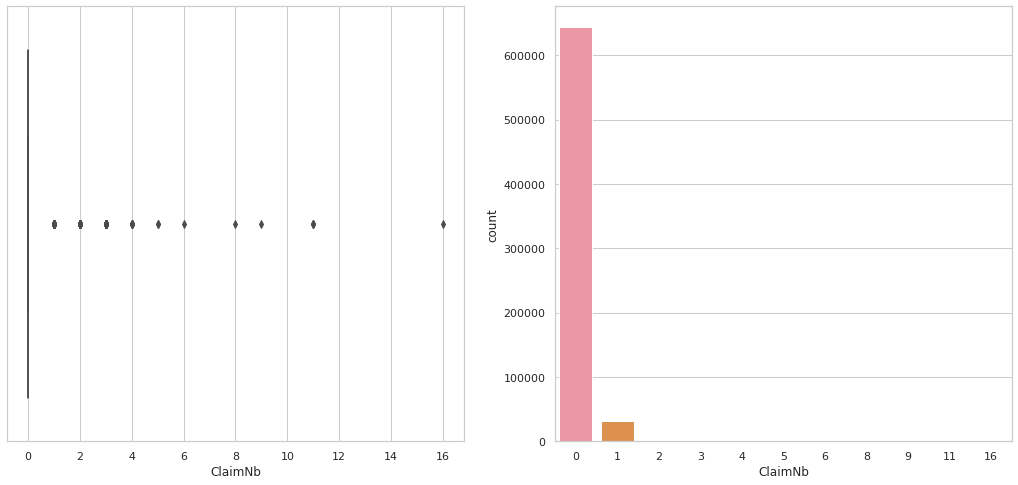

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8)) 
sns.boxplot(x=claimsdf.ClaimNb, ax=axs[0])
sns.countplot(x=claimsdf.ClaimNb, ax=axs[1])
fig.savefig("claims_box_hist.png");

#### As we can see in the graph above, almost all claim counts is null, so we'll have to take this into account when we construct our model, for instance, for a generalized linear model we should consider a zero inflated structure .

### !!! AGREGAR MAS CONCLUSIONES !!!

### EXPOSURE: Years at risk, or duration of the policy expressed in years

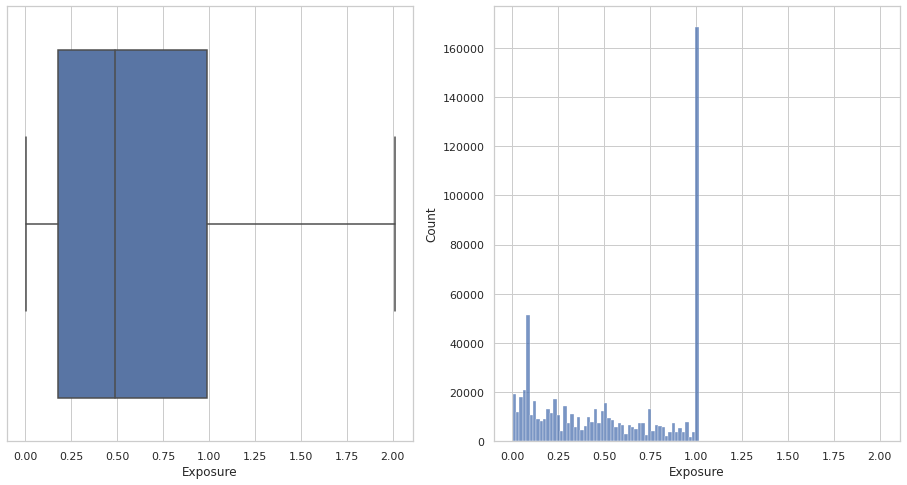

In [65]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8)) 
sns.boxplot(x=claimsdf.Exposure, ax=axs[0])
sns.histplot(x=claimsdf.Exposure, ax=axs[1])
fig.savefig("exposure_box_hist.png");

In [66]:
exposure_min = claimsdf.Exposure.min()
exposure_max = claimsdf.Exposure.max()
exposure_mean = claimsdf.Exposure.mean()
exposure_med = claimsdf.Exposure.median()
exposure_mod = claimsdf.Exposure.mode()
exposure_min, exposure_max, exposure_mean, exposure_med, exposure_mod

(0.00273224,
 2.01,
 0.5287501057690319,
 0.49,
 0    1.0
 dtype: float64)

In [67]:
claimsdf.Exposure[claimsdf.Exposure > 1].sum()

1363.34

- The minimal observed time insured in our portfolio is 1 day and the maximal time insured is 2 years. The average time insured is 193 days, the median time insured is 179 days, and only 24,79% of the policies are insured during the whole year.
- As the portfolio is for one accounting year policies, we should consider the exposures bigger than 1 as 1. On the other hand, the policies with bigger than 1 exposures accounts only for the 0.2% of the portfolio

### CATHEGORICAL VARIABLES - FEATURE ENGINEERING

#### We have 4 cathegorical variables, and 2 cathegorizable ones, namely Vehicle Age and Driver Age. We need to encode this cathegorical values for modelling pouposes (dummy-encode for regression structures or simply ordinal values for non parametric modelling like regression tree-style)

#### VEHICLE BRAND: Non ordinal , 11 CLASES

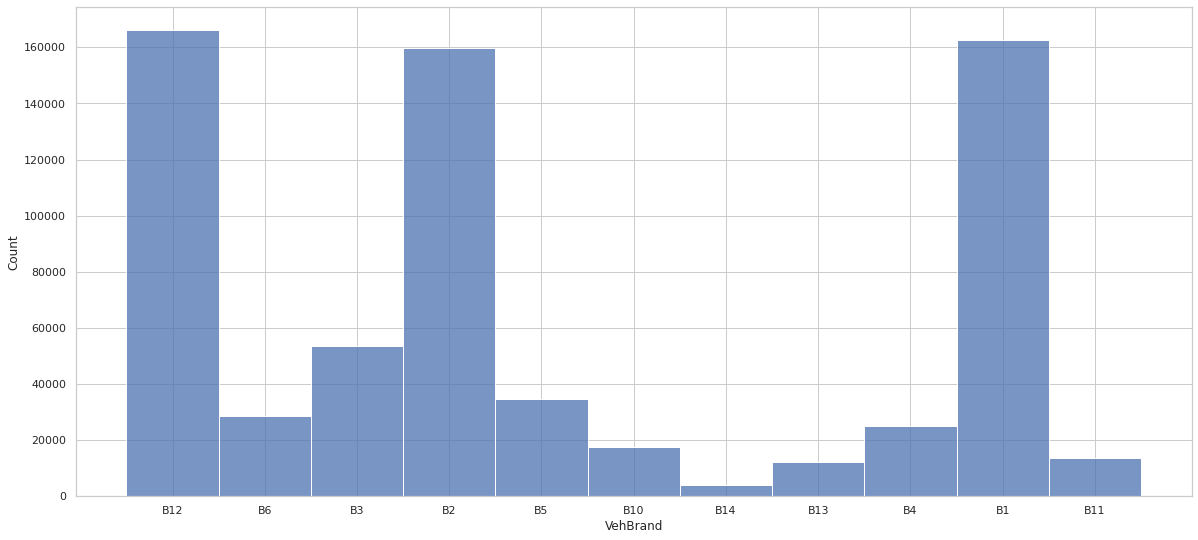

In [68]:
sns.histplot(x=claimsdf.VehBrand)
fig.savefig("vehbrand_hist.png");

In [69]:
claimsdf.VehBrand.value_counts()

B12    166024
B1     162736
B2     159861
B3      53395
B5      34753
B6      28548
B4      25179
B10     17707
B11     13585
B13     12178
B14      4047
Name: VehBrand, dtype: int64

In [70]:
dic_brands = {'B1': 1, 'B2': 2, 'B3': 3, 'B4': 4, 'B5': 5, 'B6': 6, 'B10': 7, 'B11': 8, 'B12': 9, 'B13': 10, 'B14': 11}

In [71]:
claimsdf.VehBrand = claimsdf.VehBrand.map(dic_brands)

##### VEHICLE GAS: Non ordinal, binary class

In [72]:
claimsdf.VehGas.unique()

array(['Regular', 'Diesel'], dtype=object)

In [73]:
claimsdf.VehGas.value_counts()

Regular    345877
Diesel     332136
Name: VehGas, dtype: int64

In [74]:
claimsdf = pd.get_dummies(claimsdf, columns=['VehGas'], drop_first=True)

##### AREA Code: Ordinal, 6 CLASES

In [75]:
claimsdf.Area.value_counts()

C    191880
D    151596
E    137167
A    103957
B     75459
F     17954
Name: Area, dtype: int64

In [76]:
dic_area = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6}
claimsdf.Area = claimsdf.Area.map(dic_area)

##### REGION: Non ordinal,  22 CLASSES

#### Actualizamos las regiones 

In [77]:
claimsdf.Region.unique()

array(['R82', 'R22', 'R72', 'R31', 'R91', 'R52', 'R93', 'R11', 'R24',
       'R94', 'R83', 'R54', 'R26', 'R53', 'R73', 'R42', 'R25', 'R21',
       'R41', 'R43', 'R74', 'R23'], dtype=object)

In [78]:
regions = ['Île_de_France', 'Champagne_Ardenne', 'Picardie', 'Haute_Normandie', 'Centre', 'Basse_Normandie', 'Bourgogne', 'Nord_Pas-de-Calais', 'Lorraine', 'Alsace', 'Franche_Comté', 'Pays_de_la_Loire', 'Bretagne', 'Poitou_Charentes', 'Aquitaine', 'Midi_Pyrénées', 'Limousin', 'Rhône_Alpes', 'Auvergne', 'Languedoc_Roussillon', 'Provence-Alpes_Côte d´Azur', 'Corse']
regions_code = ['R11', 'R21', 'R22', 'R23', 'R24', 'R25', 'R26', 'R31', 'R41', 'R42', 'R43', 'R52', 'R53', 'R54', 'R72', 'R73', 'R74', 'R82', 'R83', 'R91', 'R93', 'R94']
for i,j in zip(regions_code, regions):
    claimsdf.Region = claimsdf.Region.str.replace(i, j) 

In [79]:
new_regions = {'Rhône_Alpes': 'Auvergne-Rhône-Alpes',
               'Auvergne': 'Auvergne-Rhône-Alpes',
               'Bourgogne': 'Bourgogne-Franche-Comté',
               'Franche_Comté': 'Bourgogne-Franche-Comté',
               'Centre': 'Centre-Val de Loire',
               'Champagne_Ardenne': 'Grand Est',
               'Lorraine': 'Grand Est',
               'Alsace': 'Grand Est',
               'Nord_Pas-de-Calais': 'Hauts-de-France',
               'Picardie': 'Hauts-de-France',
               'Haute_Normandie': 'Normandie',
               'Basse_Normandie': 'Normandie',
               'Aquitaine': 'Nouvelle-Aquitaine',
               'Limousin': 'Nouvelle-Aquitaine',
               'Poitou-Charentes': 'Nouvelle-Aquitaine',
               'Languedoc_Roussillon': 'Occitanie',
               'Midi_Pyrénées': 'Occitanie',
               'Bretagne': 'Bretagne',
               'Corse': 'Corse',
               'Île_de_France': 'Île-de-France',
               'Pays_de_la_Loire': 'Pays de la Loire',
               'Provence-Alpes_Côte d´Azur':"Provence-Alpes-Côte d'Azur"}

In [80]:
claimsdf.Region = claimsdf.Region.map(new_regions)

In [81]:
dic_region = {'Auvergne-Rhône-Alpes': 1, 'Bourgogne-Franche-Comté': 2, 'Centre-Val de Loire': 3, 'Grand Est': 4,
               'Hauts-de-France': 5, 'Normandie': 6, 'Nouvelle-Aquitaine': 7, 'Occitanie': 8, 'Bretagne': 9,
               'Corse': 10, 'Île-de-France': 11, 'Pays de la Loire': 12, 'Provence-Alpes_Côte d´Azur': 13}

In [82]:
claimsdf.Region = claimsdf.Region.map(dic_region)

#### VEHICLE POWER (Ordered cathegorical according to the data source)

In [83]:
claimsdf.VehPower.unique()

array([ 5,  6,  7,  4,  9, 15,  8, 10, 12, 11, 14, 13])

In [84]:
def vehpower_gr(x):
    """
    ARG: A number
    Returns: If is different from 12, 13, 14 or 15, returns the number, 
    otherwise, returns 12
    """
    if x in [12, 13, 14, 15]:
        x_ = 12
        return x_
    else:
        return x

In [85]:
claimsdf['VehPower_'] = claimsdf.VehPower.apply(lambda x: vehpower_gr(x))

In [86]:
veh_power = pd.DataFrame(claimsdf.VehPower_.value_counts())
veh_power

,VehPower_
6,148976
7,145401
5,124821
4,115349
8,46956
10,31354
9,30085
11,18352
12,16719


#### VEHICLE AGE

##### Vehicle Age and Driver Age should be cathegorized in a way such that each resulting class is as homogeneous as possible in the underlying frequency.

/home/julian/miniconda3/envs/ironcon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


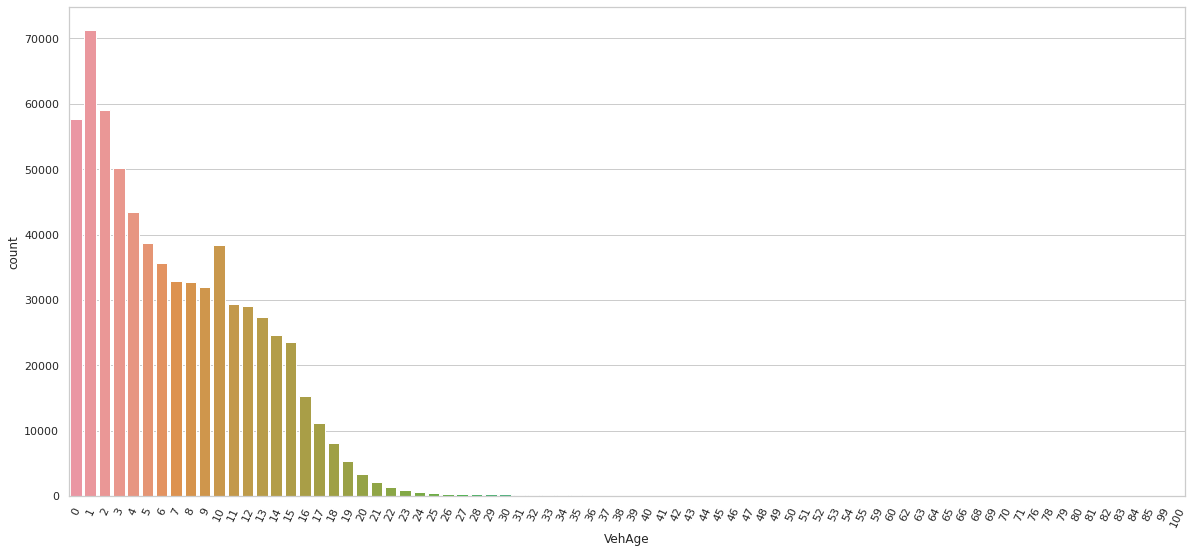

In [87]:
ax = sns.countplot(claimsdf['VehAge'])
ax.tick_params(axis='x', rotation=65);

#### As we can see in the above graph, almost all cars in the data set are under 20 years old, we will group them in 3 different classes

In [88]:
def vehage_gr(x):
    """
    ARG: A number
    Returns: If x belongs to [0,1] -> 1
             If x belongs to (1,10] -> 2
             If x belongs to (10,+inf) -> 3
    """
    if x in range(2):
        x_ = 1
        return x_
    elif x in range(1,11):
        x_ = 2
        return x_
    else:
        return 3

In [89]:
claimsdf['VehAge_'] = claimsdf.VehAge.apply(lambda x: vehage_gr(x))

In [90]:
veh_age = pd.DataFrame(claimsdf.VehAge_.value_counts())
veh_age

,VehAge_
2,363208
3,185782
1,129023


#### DRIVER AGE

#### We'll use the same criteria for the drivers age, by grouping them in 8 different clases 

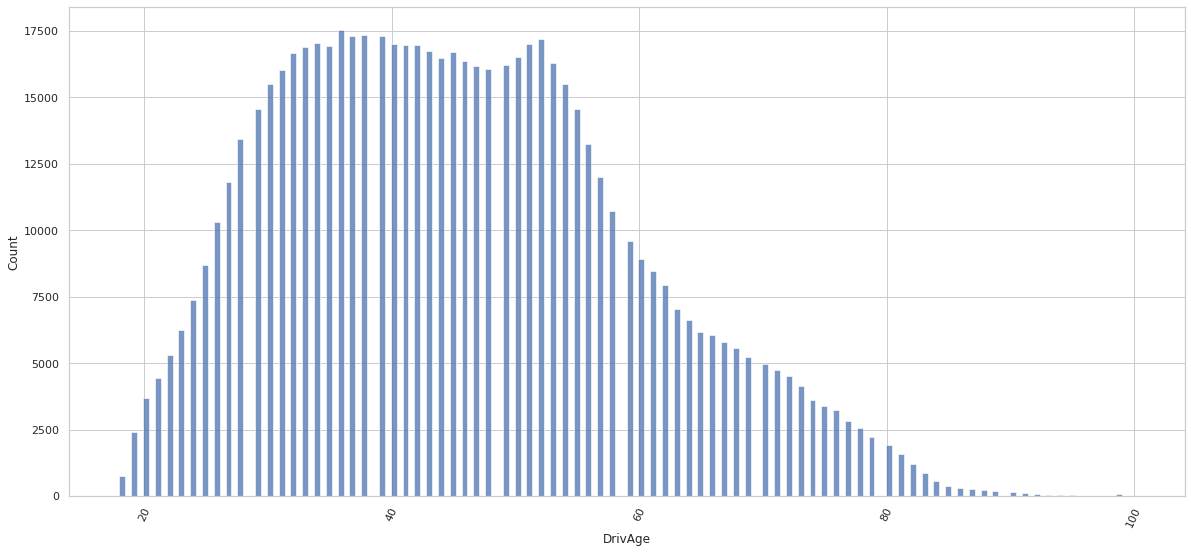

In [91]:
ax = sns.countplot(claimsdf.DrivAge)
ax.tick_params(axis='x', rotation=65)
fig.savefig("drivage_countplot.png");

In [92]:
def drivage_gr(x):
    """
    ARG: A number
    Returns: Assings a class (from 1 to 8) if x belongs to the specified ranges
    """
    if x in range(18,21):
        x_ = 1
        return x_
    elif x in range(21,26):
        x_ = 2
        return x_
    elif x in range(26,31):
        x_ = 3
        return x_
    elif x in range(31,41):
        x_ = 4
        return x_
    elif x in range(41,51):
        x_ = 5
        return x_
    elif x in range(51,61):
        x_ = 6
        return x_
    elif x in range(61,71):
        x_ = 7
        return x_

    else:
        return 8

In [93]:
claimsdf['DrivAge_'] = claimsdf.DrivAge.apply(lambda x: drivage_gr(x))

In [94]:
drivers_age = pd.DataFrame(claimsdf.DrivAge_.value_counts())
drivers_age

,DrivAge_
4,170097
5,165185
6,135014
3,65594
7,63863
8,39365
2,32079
1,6816


#### Now, we just keep the new transformed columns, and drop the ID of the policies because it makes no sense as an explanatory variable to predict the frequency of claims.

In [95]:
claimsdf.drop(columns=['IDpol', 'VehPower', 'VehAge', 'DrivAge'], inplace=True)

### CONTINUOUS VARIABLES

#### DENSITY

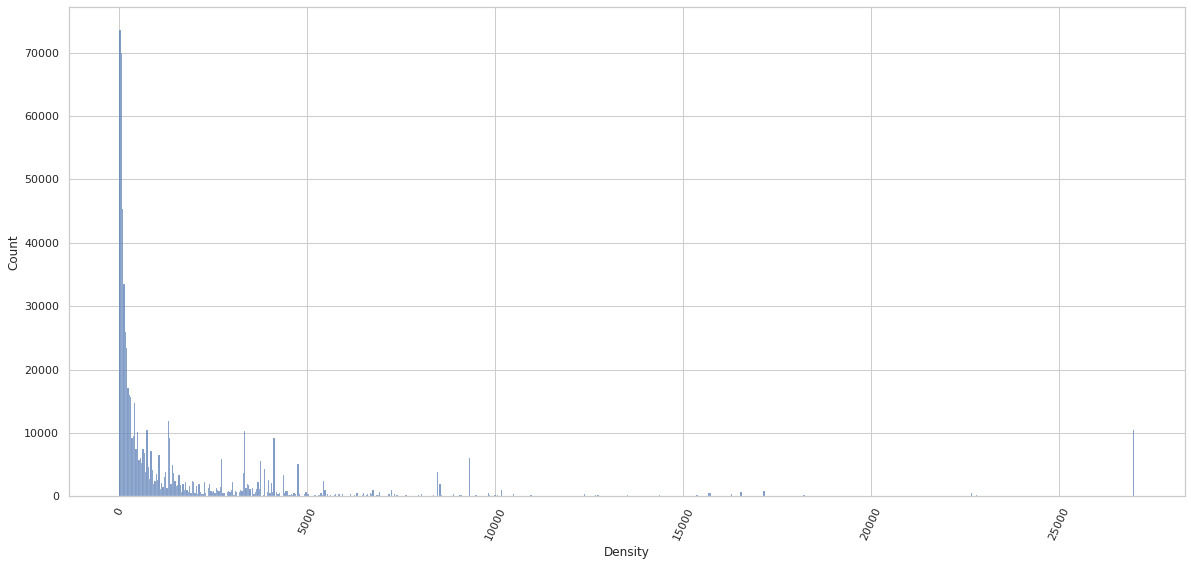

In [96]:
ax = sns.histplot(claimsdf['Density'])
ax.tick_params(axis='x', rotation=65)
fig.savefig("density_hist.png");

- We'll treat the density in a logarithmic scale

In [103]:
claimsdf['log_density'] = np.log(claimsdf.Density) 
claimsdf.drop(columns="Density", inplace=True)

In [104]:
claimsdf.head(3)

,ClaimNb,Exposure,Area,BonusMalus,VehBrand,Region,empirical_frequencies,VehGas_Regular,VehPower_,VehAge_,DrivAge_,log_density
0,1,0.10,4,50,9,1.0,10.000000,1,5,1,6,7.104144
1,1,0.77,4,50,9,1.0,1.298701,1,5,1,6,7.104144
2,1,0.75,2,50,9,5.0,1.333333,0,6,2,6,3.988984


#### BONUSMALUS (goes from 50 to 350)

- This is a score for the insured policy, its range is form 50 to 350, the smaller the score, the better driver, and it performs discounts on primes

In [119]:
claimsdf.BonusMalus.value_counts()

50     384156
100     19530
68      18791
72      18580
76      18226
        ...  
135         1
136         1
230         1
208         1
151         1
Name: BonusMalus, Length: 115, dtype: int64

## FREQUENCIES vs FEATURE COMPONENTS

#### We'll do a visual exploration of our portfolio structure in terms of exposures and observed frequencies for each of the components.

#### AREA CODES

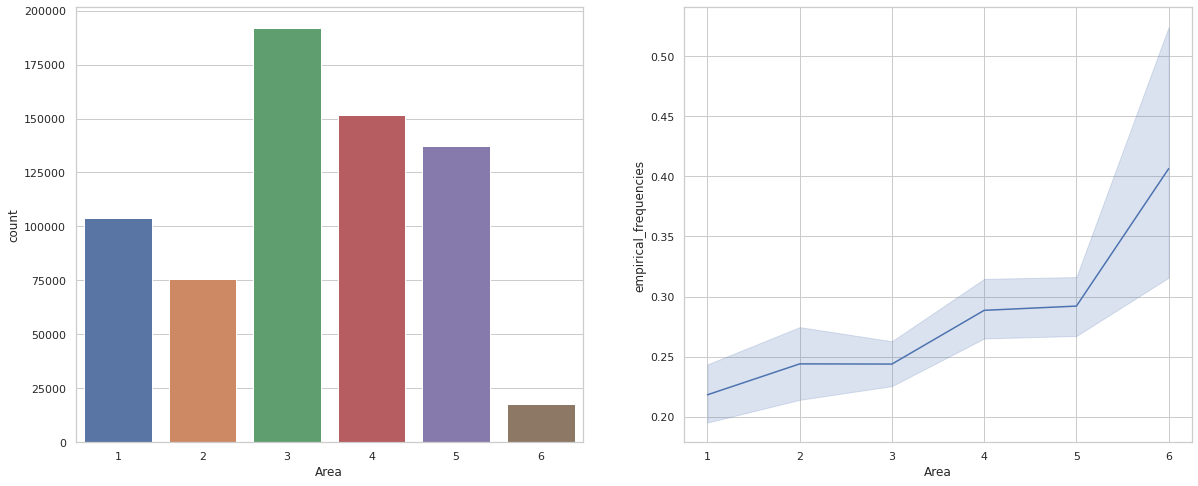

In [107]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.countplot(x=claimsdf.Area, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.Area, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("area_codes.png");

#### REGIONS AND POBLATIONAL DENSITY

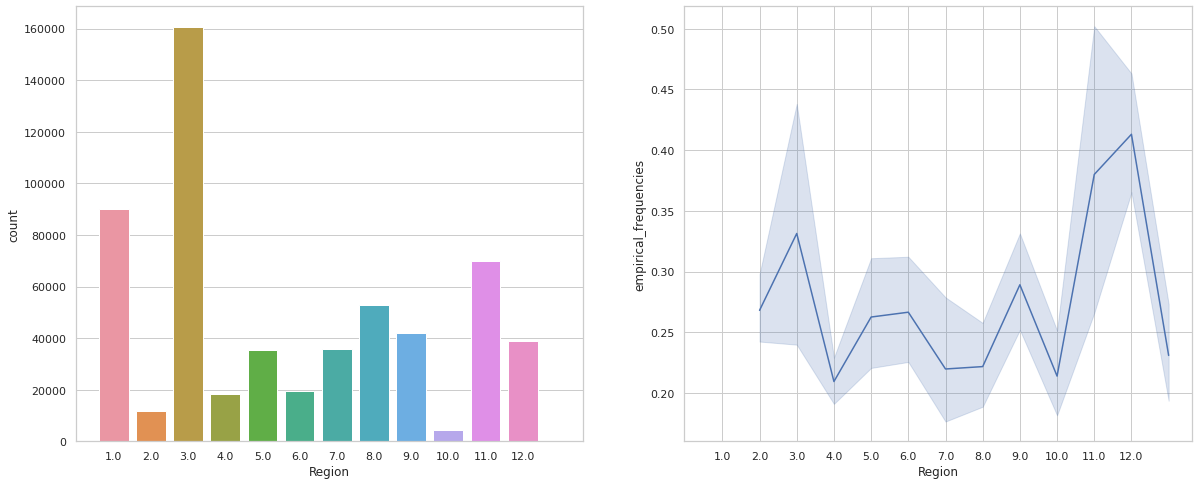

In [108]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 8))
sns.countplot(x=claimsdf.Region, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.Region, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("region_counts_empfreq.png");

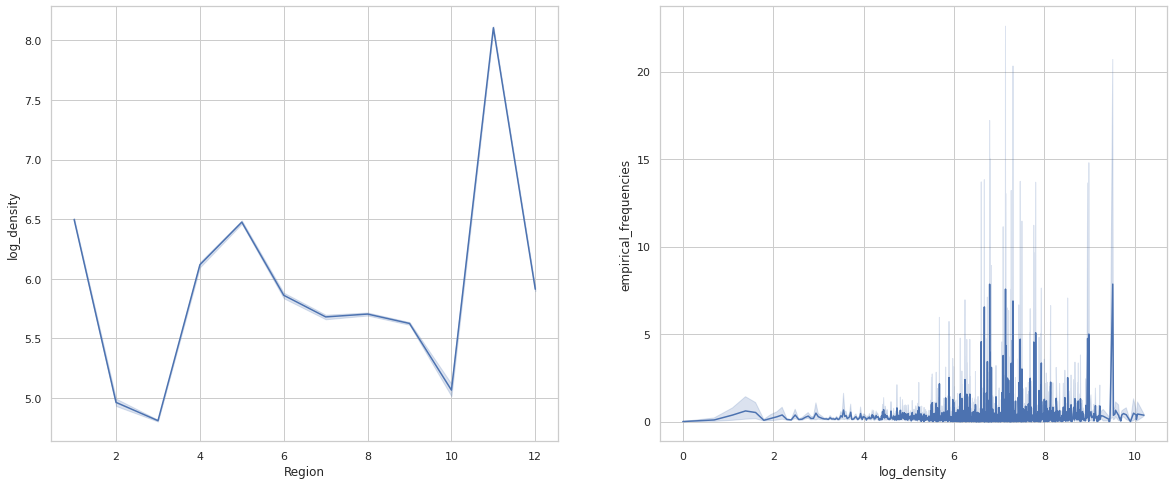

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.lineplot(data=claimsdf, x=claimsdf.Region, y=claimsdf.log_density, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.log_density, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("region_logdens.png");

#### VEHICLE GAS TYPE

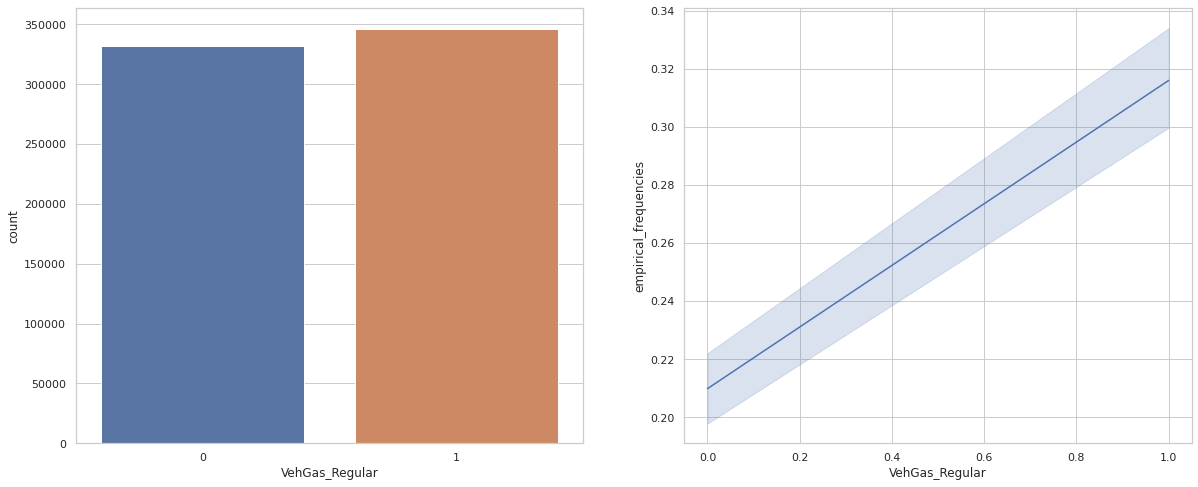

In [110]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.countplot(x=claimsdf.VehGas_Regular, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.VehGas_Regular, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("gas_counts_empfreq.png");

#### VEHICLE POWER

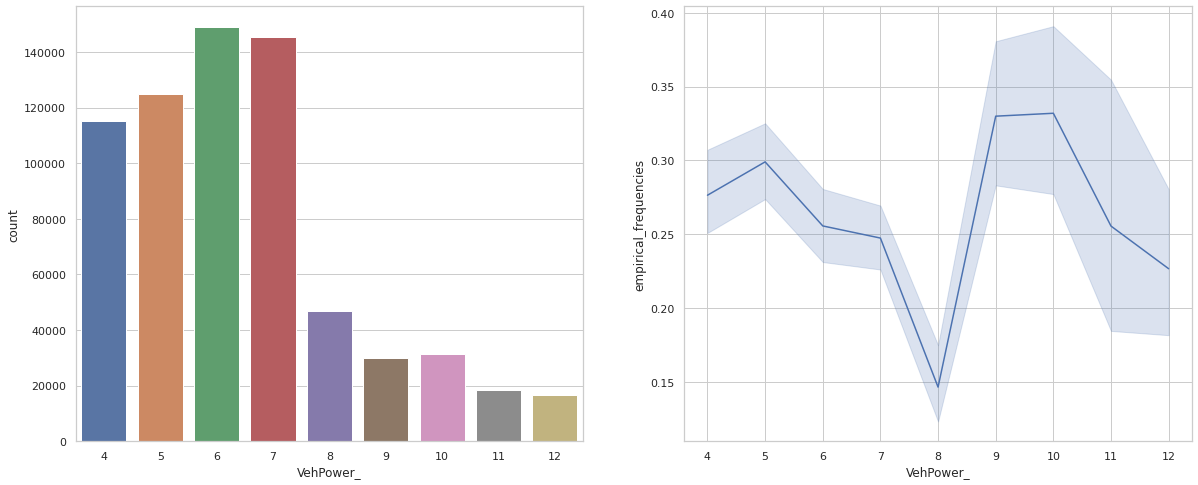

In [111]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.countplot(x=claimsdf.VehPower_, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.VehPower_, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("power_counts_empfreq.png");

#### VEHICLE AGE 

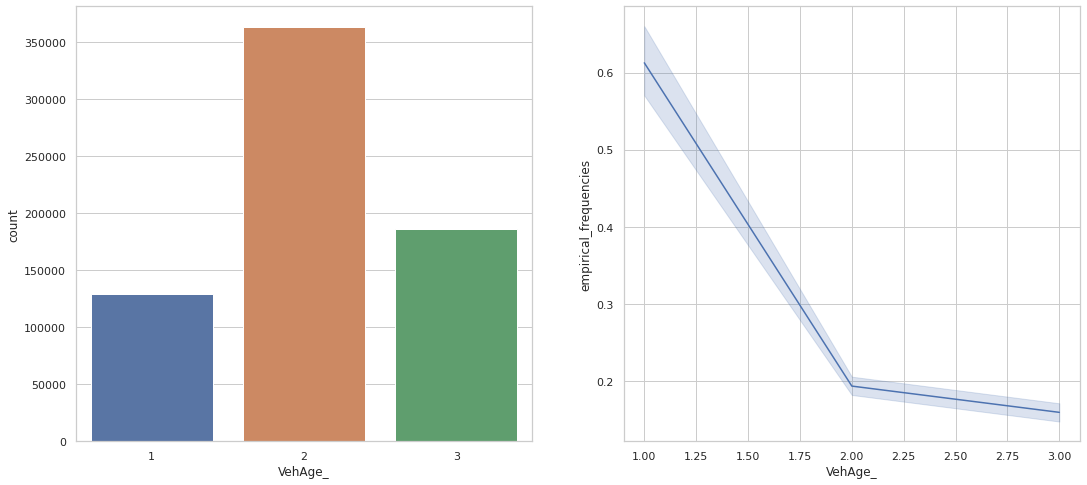

In [112]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.countplot(x=claimsdf.VehAge_, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.VehAge_, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("vehage_counts_empfreq.png");

#### DRIVERS AGE

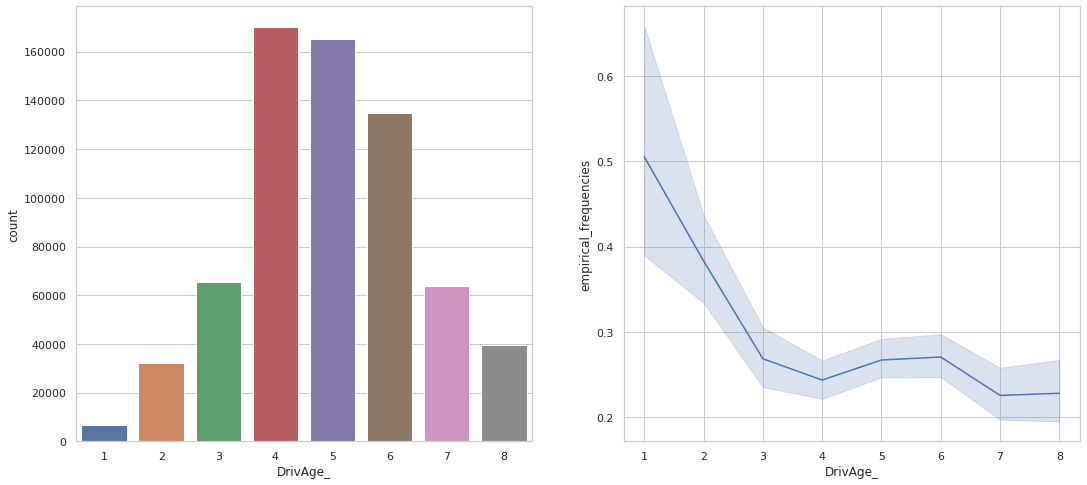

In [113]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.countplot(x=claimsdf.DrivAge_, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.DrivAge_, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("drivage_counts_empfreq.png");

#### VEHICLE BRAND 

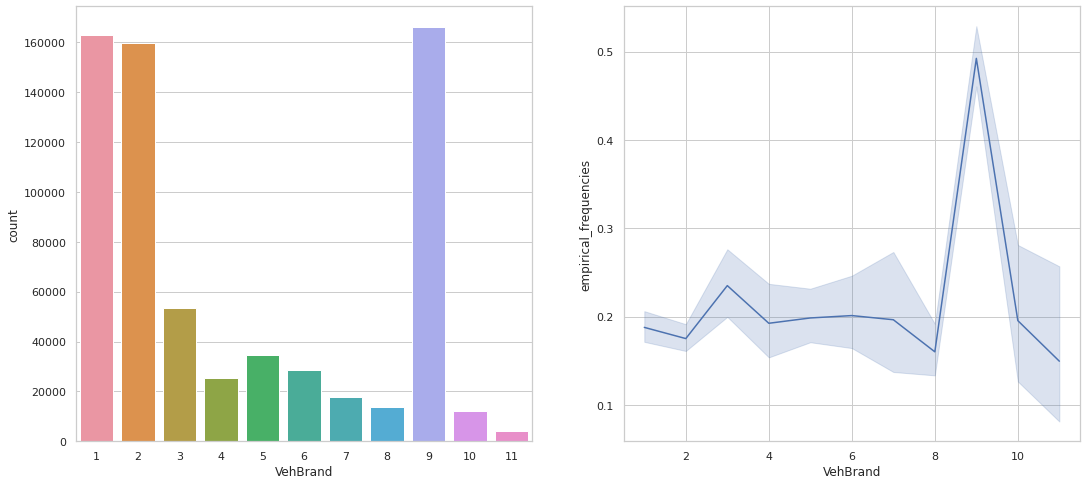

In [114]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.countplot(x=claimsdf.VehBrand, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.VehBrand, y=claimsdf.empirical_frequencies, ax=axs[1])
fig.savefig("vehbrand_counts_empfreq.png");

#### BONUS MALUS

In [115]:
def bonusmalus_gr(x):
    """
    ARG: A number
    Returns: Assings a class (from 1 to 7) if x belongs to the specified ranges
    """
    if x in range(50, 61):
        x_ = 1
        return x_
    elif x in range(61,71):
        x_ = 2
        return x_
    elif x in range(71,81):
        x_ = 3
        return x_
    elif x in range(81,91):
        x_ = 4
        return x_
    elif x in range(91,101):
        x_ = 5
        return x_
    elif x in range(101,151):
        x_ = 6
        return x_
    else:
        x_ = 7
        return x_

In [116]:
claimsdf['BonusMalus_'] = claimsdf.BonusMalus.apply(lambda x: bonusmalus_gr(x))

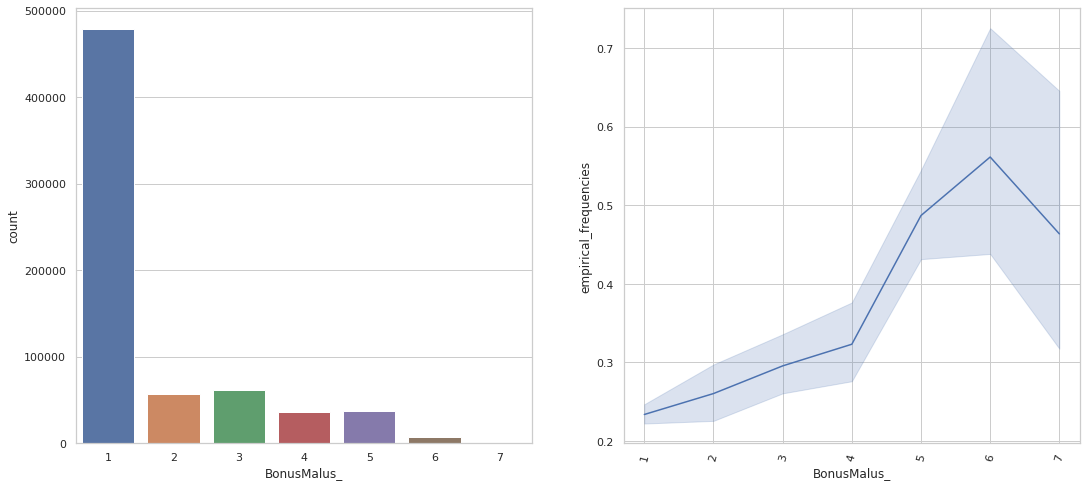

In [117]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.countplot(x=claimsdf.BonusMalus_, ax=axs[0])
sns.lineplot(data=claimsdf, x=claimsdf.BonusMalus_, y=claimsdf.empirical_frequencies, ax=axs[1])
plt.xticks(rotation=75)
fig.savefig("bonusmalus_counts_empfreq.png");

## CORRELATION ANALYSIS 

#### Now, we proceed to export a csv file with the cleaned data frame for modelling

In [120]:
correlations = claimsdf.corr()

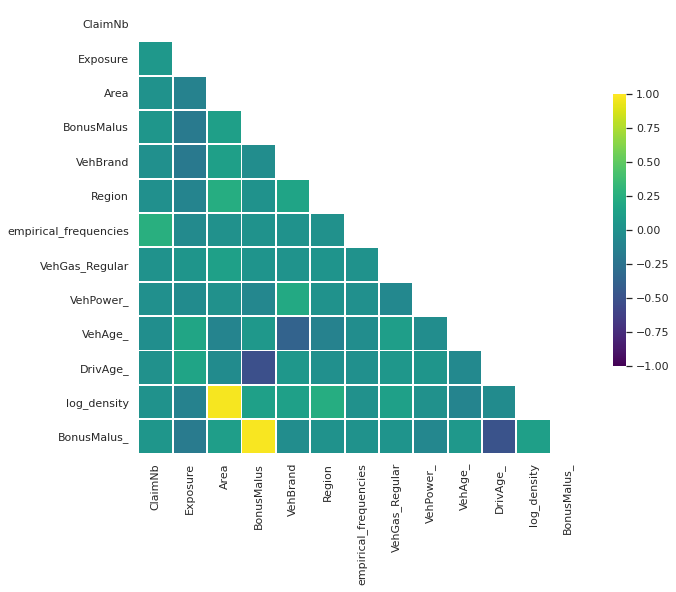

In [121]:
fig, ax = plt.subplots(figsize=(10,10)) 
mask = np.triu(np.ones_like(correlations, dtype=bool))
color_map = sns.diverging_palette(0, 10, as_cmap=True) 
sns.heatmap(correlations, 
            cmap="viridis",
            mask=mask,
            vmax=1,
            vmin=-1,
            square=True, 
            linewidth=.8, 
            cbar_kws={"shrink": .5},
            ax=ax
)
fig.savefig("correlations.png");

In [105]:
claimsdf.to_csv('claimsdf_1.csv', index = False)